Here we show some examples that how to fit a simple model

In [1]:
from fit import fit, fit_parallel, fit_bms
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns
%matplotlib inline

eps = np.finfo(np.float32).eps

In [2]:
# linear regression
a = 2
b = 1
noise = 5

def generatedata_linear(a,b,noise):
    x = np.arange(1,100,1)
    y = a * x + b + noise * np.random.rand(x.size)
    return {'x':x, 'y':y}

To define a loss function (e.g., negative loglikelihood function), we set three inputs: params (1st), data (2nd), and priors (3rd).

In [3]:
# note that the parameter should always be the 1st input here
def nll(params, data, p_priors):
    x = data['x']    
    a = params[0]
    b = params[1]
    predict_y = a*x+b

    pp = norm.pdf(data['y'], loc=predict_y, scale=noise)
    # to avoid nan
    pp = 0.999*pp + eps
    if p_priors: # for now we ignore prior
        pass
    return -np.log(pp).sum()

In [5]:
data = generatedata_linear(a, b, noise)
# define prior
p_priors = [norm(loc=1, scale=10), norm(loc=1, scale=10)]
# perform a single fit
fit(nll, data, bnds=[(0.1, 5), (0.1, 5)], pbnds=[(0.1, 5), (0.1, 5)], p_name=list(data.keys()), p_priors=p_priors, method='map', alg='BFGS')

{'log_post': np.float64(-254.3302523776359),
 'log_like': np.float64(-254.3302523776359),
 'param': array([1.99522655, 3.73759804]),
 'param_name': ['x', 'y'],
 'n_param': 2,
 'aic': np.float64(512.6605047552719),
 'bic': np.float64(519.2370388166609),
 'H': array([[1.31297123e+04, 1.97775873e+02],
        [1.97775873e+02, 3.96385413e+00]]),
 'H_inv': array([[ 3.06587038e-04, -1.52971117e-02],
        [-1.52971117e-02,  1.01552668e+00]])}

In [9]:
from pathos import multiprocessing # recommand pathos

pool = multiprocessing.Pool(2)
# fit the same subject multiple times
fit_parallel(pool, nll, data, bnds=[(0.1, 5), (0.1, 5)], pbnds=[(0.1, 5), (0.1, 5)], p_name=list(data.keys()), p_priors=p_priors, method='map', alg='BFGS', n_fits=40)    

	Num of lowest loss: 40/40


{'log_post': np.float64(-254.3302523776357),
 'log_like': np.float64(-254.3302523776357),
 'param': array([1.99522657, 3.73759708]),
 'param_name': ['x', 'y'],
 'n_param': 2,
 'aic': np.float64(512.6605047552714),
 'bic': np.float64(519.2370388166605),
 'H': array([[1.31368557e+04, 1.98042701e+02],
        [1.98042701e+02, 3.96063691e+00]]),
 'H_inv': array([[ 3.09197596e-04, -1.54607273e-02],
        [-1.54607273e-02,  1.02556338e+00]])}

# model comparison

Define another model and simulate multiple subjects. To showcase how to use AIC/BIC/PXP

In [10]:
nSubject = 10
subj_name = [f'subj{i:02d}' for i in range(nSubject)]

# linear regression
a1 = np.random.rand(nSubject) + 2
b1 = np.random.rand(nSubject) + 1
# simulate data
data_linear = [generatedata_linear(a,b, noise) for (a,b) in zip(a1,b1)]

p_priors = [norm(loc=2, scale=10), norm(loc=1, scale=10)]
fit_results = [fit_parallel(pool, nll, dd, bnds=[(0.1, 5), (0.1, 5)], pbnds=[(0.1, 5), (0.1, 5)], p_name=list(dd.keys()), p_priors=p_priors, method='mle', alg='BFGS', n_fits=40) for dd in data_linear]


fit_linear = dict(zip(subj_name, fit_results))

	Num of lowest loss: 40/40
	Num of lowest loss: 40/40
	Num of lowest loss: 40/40
	Num of lowest loss: 40/40
	Num of lowest loss: 40/40
	Num of lowest loss: 40/40
	Num of lowest loss: 40/40
	Num of lowest loss: 40/40
	Num of lowest loss: 40/40
	Num of lowest loss: 40/40


In [11]:
# 3-order polynomial fit
# note that the parameter should always be the 1st input here
def nll_poly(params, data, p_priors):
    x = data['x']    
    a = params[0]
    b = params[1]
    c = params[2]
    predict_y = a*x**x + b*x + c

    pp = norm.pdf(data['y'], loc=predict_y, scale=noise)
    # to avoid nan
    pp = 0.999*pp + eps
    if p_priors: # for now we ignore prior
        pass
    return -np.log(pp).sum()
    

p_priors = [norm(loc=2, scale=10), norm(loc=1, scale=10), norm(loc=5, scale=10)]
fit_results = [fit_parallel(pool, nll_poly, dd, bnds=[(0.1, 10), (0.1, 10), (0.1, 10)], pbnds=[(0.1, 10), (0.1, 10), (0.1, 10)], p_name=list(dd.keys()), p_priors=p_priors, method='mle', alg='BFGS', n_fits=40) for dd in data_linear] # 我们这里fit data_linear

fit_poly = dict(zip(subj_name, fit_results))

	Num of lowest loss: 1/40
	Num of lowest loss: 7/40
	Num of lowest loss: 2/40
	Num of lowest loss: 3/40
	Num of lowest loss: 1/40
	Num of lowest loss: 1/40
	Num of lowest loss: 1/40
	Num of lowest loss: 1/40
	Num of lowest loss: 1/40
	Num of lowest loss: 1/40


# Visualize bayesian model selection (pxp) 

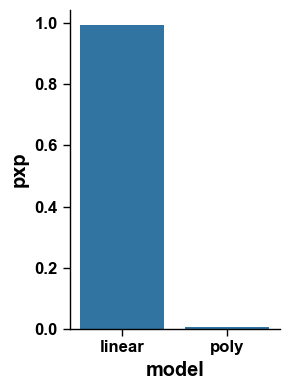

In [12]:
models = ['linear', 'poly']
bic_linear = [fit_linear[i]['bic'] for i in fit_linear.keys()]
bic_poly = [fit_poly[i]['bic'] for i in fit_poly.keys()]

all_subj_info = [{'bic':bic_linear}, {'bic':bic_poly}]

bms_results = fit_bms(all_subj_info, use_bic=True)
pxp = pd.DataFrame.from_dict({'pxp': bms_results['pxp'], 'model': models})

# visualize pxp results
plt.figure(figsize=(3,4))
sns.barplot(data=pxp, x='model',y='pxp')
plt.show()

# Visualize AIC/BIC

In [13]:
models = ['linear', 'poly'] # we put the best model at the first
bestModel = 'linear' # if we know the best model

cols = ['NLL', 'AIC', 'BIC', 'model', 'sub_id']
llh_results = {k: [] for k in cols}
fit_info = [fit_linear, fit_poly]
for m,f in zip(models, fit_info):    
    nll = [-f[idx]['log_like'] for idx in subj_name]
    aic = [f[idx]['aic'] for idx in subj_name]
    bic = [f[idx]['bic'] for idx in subj_name]
    llh_results['NLL'] += nll
    llh_results['AIC'] += aic
    llh_results['BIC'] += bic
    llh_results['model'] += [m]*len(nll)
    llh_results['sub_id'] += list(subj_name)

llh_results = pd.DataFrame.from_dict(llh_results)

# Important here
# We typically plot the delta NLL, AIC, BIC as compared to the best model
for c in ['NLL', 'BIC', 'AIC']:
    tar_crs = len(models)*list(llh_results.query(f'model=="{bestModel}"')[c].values)
    subtrack = tar_crs
    llh_results[c] -= subtrack 

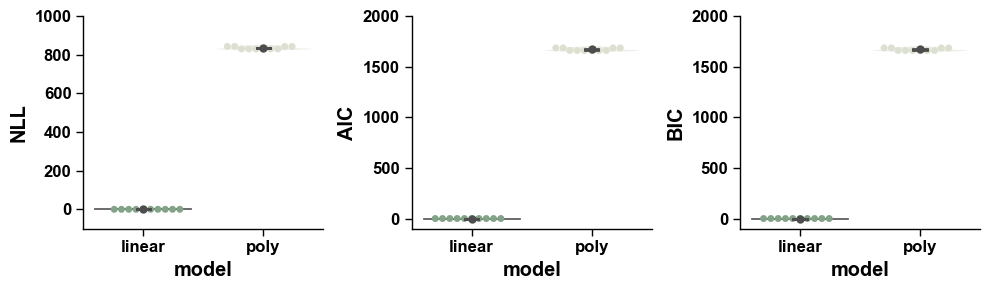

In [14]:
from sciviz import sciviz as viz
# Now visualize
fig, ax = plt.subplots(1, 3, figsize=(10,3))
plt.sca(ax[0])
plt.ylim([-100,1000])
viz.violin(ax[0], data = llh_results, x = 'model', y='NLL', order=models, palette=viz.greenPairs, scatter_size=5)

plt.sca(ax[1])
plt.ylim([-100,2000])
viz.violin(ax[1], data = llh_results, x = 'model', y='AIC', order=models, palette=viz.greenPairs, scatter_size=5)

plt.sca(ax[2])
plt.ylim([-100,2000])
viz.violin(ax[2], data = llh_results, x = 'model', y='BIC', order=models, palette=viz.greenPairs,scatter_size=5)

plt.show()